# 06 - Hyperparameter Tuning

This notebook focuses on tuning the hyperparameters of our classification models  
(Logistic Regression, Decision Tree, Random Forest, and SVM) to improve their performance.

We will use:
- GridSearchCV for exhaustive search on parameter grids.
- RandomizedSearchCV for faster, random parameter search (optional).
  
The models tuned here are the same as those trained previously in `04_supervised_learning.ipynb`.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

import joblib
import os


## Step 1: Load Dataset and Split Data

Load the dataset with selected features and split into train/test sets (80/20) with stratification.


In [2]:
df = pd.read_csv('data/heart_disease_selected.csv')

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape : {X_test.shape}")


Training data shape: (237, 10)
Testing data shape : (60, 10)


## Step 2: Define Models and Hyperparameter Grids

Define the classification models and their respective hyperparameter grids for tuning.


In [3]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
}


## Step 3: Hyperparameter Tuning with GridSearchCV

Perform exhaustive hyperparameter search using 5-fold cross-validation and ROC AUC scoring.


In [4]:
best_models = {}
tuning_results = {}

for name in models:
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    tuning_results[name] = grid_search.cv_results_
    
    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best CV ROC AUC: {grid_search.best_score_:.4f}\n")


Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for Logistic Regression: {'C': 0.01, 'penalty': 'l2'}
Best CV ROC AUC: 0.9027

Tuning Decision Tree...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best params for Decision Tree: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV ROC AUC: 0.7816

Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV ROC AUC: 0.8871

Tuning SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV ROC AUC: 0.8942



## Step 4: Evaluate Tuned Models on Test Set

Evaluate the performance of the best tuned models on the hold-out test set.


--- Logistic Regression (Tuned) ---
Accuracy : 0.867
Precision: 0.857
Recall   : 0.857
F1-Score : 0.857
AUC Score: 0.943

Confusion Matrix:
[[28  4]
 [ 4 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

--- Decision Tree (Tuned) ---
Accuracy : 0.833
Precision: 0.846
Recall   : 0.786
F1-Score : 0.815
AUC Score: 0.897

Confusion Matrix:
[[28  4]
 [ 6 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.

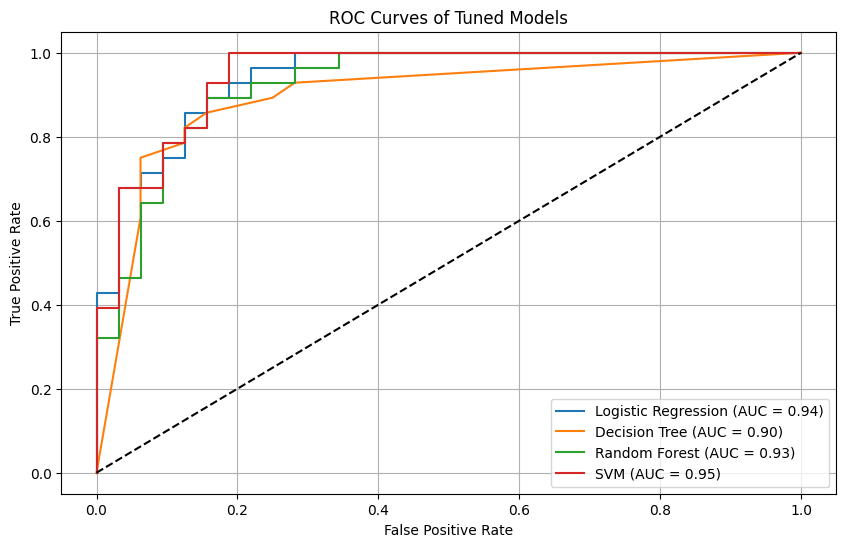

In [5]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"--- {name} (Tuned) ---")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-Score : {f1:.3f}")
    if auc is not None:
        print(f"AUC Score: {auc:.3f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.figure(figsize=(10, 6))
for name, model in best_models.items():
    evaluate_model(name, model, X_test, y_test)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Tuned Models')
plt.legend()
plt.grid(True)
plt.show()


## Step 5: Save Tuned Models

Save all the best tuned models for future deployment.


In [ ]:
os.makedirs('models', exist_ok=True)

for name, model in best_models.items():
    filename = f"models/{name.lower().replace(' ', '_')}_tuned.pkl"
    joblib.dump(model, filename)

print("All tuned models saved successfully.")

## Summary

- Successfully tuned hyperparameters of all classification models.
- Evaluated their performance on the test set with ROC AUC as main metric.
- Saved the tuned models for downstream deployment.
- Next steps: Model deployment and building the interactive Streamlit UI.
